# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [2]:
bandit0 = BanditProblem(0)

In [3]:
bandit0.get_num_arms()

3

In [4]:
bandit0.get_reward(arm=0)

1.8255111545554434

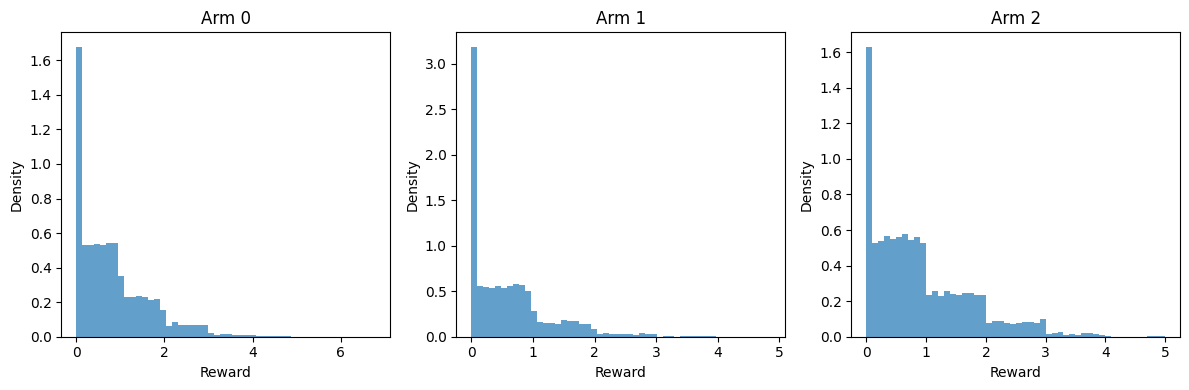

In [ ]:
# YOUR CHANGES HERE

import matplotlib.pyplot as plt

bandit0 = BanditProblem(0)

num_samples = 10000
num_arms = bandit0.get_num_arms()

rewards = {}

for arm in range(num_arms):
    rewards[arm] = [bandit0.get_reward(arm) for _ in range(num_samples)]

# plot 
plt.figure(figsize=(12, 4))

for arm in range(num_arms):
    plt.subplot(1, num_arms, arm + 1)
    plt.hist(rewards[arm], bins=50, density=True, alpha=0.7)
    plt.title(f"Arm {arm}")
    plt.xlabel("Reward")
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and give a single sentence justifying your choice and rejecting the alternatives.
Keep your explanation concise; you should be able to justify your choice solely based on the type of numbers observed, and whether those match the bandit algorithms that you have learned.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2026.

In [18]:
# YOUR CHANGES HERE

import numpy as np

# set arm beliefs
class UCB1:
    def __init__(self, n_arms: int):
        self.n_arms = n_arms 
        self.counts = [0] * n_arms # times arm pulled
        self.values = [0.0] * n_arms  

    def select_arm(self) -> int: # next arm pull
        
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm

        total_counts = sum(self.counts)
# arm score
        ucb_values = [0.0] * self.n_arms
        for arm in range(self.n_arms):
            bonus = np.sqrt((2.0 * np.log(total_counts)) / self.counts[arm])
            ucb_values[arm] = self.values[arm] + bonus

        return int(np.argmax(ucb_values))

    def update(self, chosen_arm: int, reward: float) -> None:
        
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]

        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value


# 1000 act 2026 seed
bandit = BanditProblem(2026)
K = bandit.get_num_arms()
T = 1000

actions = np.zeros(T, dtype=int)
rewards = np.zeros(T, dtype=float)

ucb = UCB1(K)

for t in range(T):
    a = ucb.select_arm()
    r = bandit.get_reward(a)

    actions[t] = a
    rewards[t] = r

    ucb.update(a, r)


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [17]:
# YOUR CHANGES HERE

with open("history.tsv", "w") as f:
    f.write("action\treward\n")
    for a, r in zip(actions, rewards):
        f.write(f"{a}\t{r}\n")

Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [ ]:
# YOUR CHANGES HERE

actions = []
rewards = []

# part 2
with open("history.tsv", "r") as f:
    header = f.readline()  
    for line in f:
        a_str, r_str = line.strip().split("\t")
        actions.append(int(a_str))
        rewards.append(float(r_str))

# allow actions == a
actions = np.array(actions, dtype=int)
rewards = np.array(rewards, dtype=float)

# number of arms
K = int(actions.max()) + 1  

rows = []
for a in range(K):
    arm_rewards = rewards[actions == a]
    
    if arm_rewards.size == 0:
        mn = np.nan
        mu = np.nan
        mx = np.nan
    else:
        mn = float(np.min(arm_rewards))
        mu = float(np.mean(arm_rewards))
        mx = float(np.max(arm_rewards))
    rows.append((a, mn, mu, mx))



In [ ]:
with open("actions.tsv", "w") as f:
    f.write("action\tmin_reward\tmean_reward\tmax_reward\n")
    for a, mn, mu, mx in rows:
        f.write(f"{a}\t{mn}\t{mu}\t{mx}\n")

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Estimate the regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

These estimates should be based on your previous action statistics; you should not use the true action values from the bandit code.

In [ ]:
# YOUR CHANGES HERE

actions = []
mean_rewards = []

# part 3
with open("actions.tsv", "r") as f:
    header = f.readline()  
    for line in f:
        a, mn, mu, mx = line.strip().split("\t")
        actions.append(int(a))
        mean_rewards.append(float(mu))

actions = np.array(actions)
mean_rewards = np.array(mean_rewards)

K = len(mean_rewards)
T = 1000

In [11]:
best_mean = np.max(mean_rewards)

In [ ]:
# mean rewards per arm 
uniform_expected_reward = np.mean(mean_rewards)
uniform_regret = T * (best_mean - uniform_expected_reward)

In [13]:
just_regrets = {}

for i in range(K):
    just_regrets[f"just-{i}"] = T * (best_mean - mean_rewards[i])

In [ ]:
hist_actions = []
# problem 2
with open("history.tsv", "r") as f:
    f.readline()
    for line in f:
        a, _ = line.strip().split("\t")
        hist_actions.append(int(a))

hist_actions = np.array(hist_actions)

# counts
counts = np.bincount(hist_actions, minlength=K)
freqs = counts / T

actual_expected_reward = np.sum(freqs * mean_rewards)
actual_regret = T * (best_mean - actual_expected_reward)

Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [15]:
# YOUR CHANGES HERE

with open("strategies.tsv", "w") as f:
    f.write("strategy\tregret\n")
    f.write(f"uniform\t{uniform_regret}\n")
    for k, v in just_regrets.items():
        f.write(f"{k}\t{v}\n")
    f.write(f"actual\t{actual_regret}\n")

Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.